### Check the sea-level measurements for one year for preliminary mean sea level

This notebook computes the preliminary mean sea level. To run this notebook please download the data using the makefiles in data/psmsl and data/waterbase. The official figures are not available until Rijkswaterstaat delivers data to the PSMSL (often in june, and on request). 

The data for the last few years are compared to the PSMSL data. We use the metric data in this notebook as the RLR version is part of the validation for the final figures.

In [1]:
import json
import logging
import datetime 
import io


import numpy as np
import pandas as pd

import requests

from dateutil.relativedelta import relativedelta
import pytz

from tqdm import tqdm_notebook as tqdm
import matplotlib.pyplot as plt

from ipywidgets import interact

%matplotlib inline
logger = logging.getLogger('notebook')

In [2]:
# note that there are two stations for IJmuiden.
# The station was moved from the sluices to outside of the harbor in 1981.
ids = ['DELFZL', 'DENHDR', 'HARLGN', 'HOEKVHLD', 'IJMDBTHVN', 'VLISSGN']
current_year = 2017

In [3]:
# Read all the files, downloaded from waterbase (live.waterbase.nl)
# The official source is not functioning properly (sent issue to servicedesk data)
# This only does a missing/value check
# Quality flags are not available in the waterbase export
# Detailed analysis trend breaks, consistency between measurements is done later
records = []
for station in ids:
    for year in (2015, 2016, 2017):
        df = pd.read_csv('/Users/baart_f/src/sealevel/data/waterbase/%s-%s.txt' % (station, year), skiprows=3, sep=';')
        # there should be no missings
        assert df['waarde'].isna().sum() == 0
        # all values should be within this range
        # if not check what's happening
        assert df['waarde'].min() > -400
        assert df['waarde'].max() < 600
        mean = df.waarde.mean()
        records.append({
            'station': station,
            'year': year,
            'mean': mean
        })
        


In [4]:
# merge all the records to get a list of mean sea level per year
latest_df = pd.DataFrame(records)
# check the mean for 2017
latest_df[['station', 'year', 'mean']]

,station,year,mean
0,DELFZL,2015,17.914897
1,DELFZL,2016,14.388020
2,DELFZL,2017,19.950985
3,DENHDR,2015,3.628919
4,DENHDR,2016,1.770723
5,DENHDR,2017,5.541436
6,HARLGN,2015,14.044711
7,HARLGN,2016,10.011778
8,HARLGN,2017,14.616878
9,HOEKVHLD,2015,10.940183


In [5]:
# read the latest data 
sources = {}
for station in ids:
    if station == 'IJMDNDSS':
        continue
    df = pd.read_csv('/Users/baart_f/src/sealevel/data/waterbase/%s-%s.txt' % (station, current_year), skiprows=3, sep=';')
    df['date'] = pd.to_datetime(df['datum'] + ' ' + df['tijd'])
    # all units should be cm
    assert (df.eenheid == 'cm').all()
    sources[station] = df



In [6]:
# this is the data, a bit verbose but the relevant things are datum tijd and waarde
sources[ids[0]].tail()

,locatie,waarnemingssoort,datum,tijd,bepalingsgrenscode,waarde,eenheid,hoedanigheid,anamet,ogi,vat,bemhgt,refvlk,EPSG,x/lat,y/long,orgaan,"biotaxon (cijfercode,biotaxon omschrijving,biotaxon Nederlandse naam)",date
531812,Delfzijl,Waterhoogte in cm t.o.v. normaal amsterdams pe...,2017-12-30,00:56,NaN,-103,cm,T.o.v. Normaal Amsterdams Peil,Rek. gem. waterhoogte over vorige 5 en volgend...,Nationaal,Vlotterniveaumeter - type DNM,NVT,NVT,7415,258000,594430,NVT,"NVT,NVT,Niet van toepassing",2017-12-30 00:56:00
531813,Delfzijl,Waterhoogte in cm t.o.v. normaal amsterdams pe...,2017-12-30,00:57,NaN,-104,cm,T.o.v. Normaal Amsterdams Peil,Rek. gem. waterhoogte over vorige 5 en volgend...,Nationaal,Vlotterniveaumeter - type DNM,NVT,NVT,7415,258000,594430,NVT,"NVT,NVT,Niet van toepassing",2017-12-30 00:57:00
531814,Delfzijl,Waterhoogte in cm t.o.v. normaal amsterdams pe...,2017-12-30,00:58,NaN,-104,cm,T.o.v. Normaal Amsterdams Peil,Rek. gem. waterhoogte over vorige 5 en volgend...,Nationaal,Vlotterniveaumeter - type DNM,NVT,NVT,7415,258000,594430,NVT,"NVT,NVT,Niet van toepassing",2017-12-30 00:58:00
531815,Delfzijl,Waterhoogte in cm t.o.v. normaal amsterdams pe...,2017-12-30,00:59,NaN,-106,cm,T.o.v. Normaal Amsterdams Peil,Rek. gem. waterhoogte over vorige 5 en volgend...,Nationaal,Vlotterniveaumeter - type DNM,NVT,NVT,7415,258000,594430,NVT,"NVT,NVT,Niet van toepassing",2017-12-30 00:59:00
531816,Delfzijl,Waterhoogte in cm t.o.v. normaal amsterdams pe...,2017-12-30,01:00,NaN,-107,cm,T.o.v. Normaal Amsterdams Peil,Rek. gem. waterhoogte over vorige 5 en volgend...,Nationaal,Vlotterniveaumeter - type DNM,NVT,NVT,7415,258000,594430,NVT,"NVT,NVT,Niet van toepassing",2017-12-30 01:00:00


In [7]:
# compute the maximum water levels
records = []
for station, df in sources.items():
    date_df = df.set_index('date')
    
    max_date = date_df['waarde'].idxmax()
    record = {
        'station': station, 
        'date': max_date, 
        'value': date_df['waarde'].loc[max_date]
    }
    records.append(record)
annual_maxima_df = pd.DataFrame(records)
annual_maxima_df

,date,station,value
0,2017-01-14 00:23:00,DELFZL,394
1,2017-01-13 19:58:00,DENHDR,213
2,2017-01-13 21:33:00,HARLGN,299
3,2017-12-08 05:58:00,HOEKVHLD,238
4,2017-01-13 16:20:00,IJMDBTHVN,237
5,2017-01-14 02:54:00,VLISSGN,336


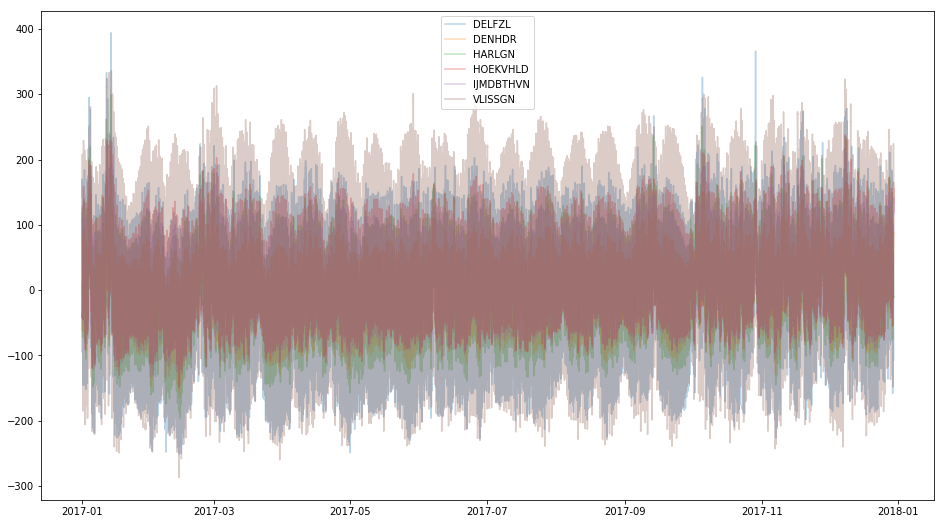

In [8]:
# bokeh is a bit slow when plotting all 3M records at once
# so we'll use matplotlib for now
fig, ax = plt.subplots(figsize=(16, 9))
for station, df in sources.items():
    index = df.set_index('date').index
    ax.plot(index.to_pydatetime(), df['waarde'], '-', label=station, alpha=0.3)
ax.legend(loc='best');


In [9]:
# plot a window of a week

def plot(weeks=(0, 51)):
    fig, ax = plt.subplots(figsize=(16, 9))
    for station, df in sources.items():
        selected = df[
            np.logical_and(
                df['date'] >= datetime.datetime(2017, 1, 1) + datetime.timedelta(weeks=weeks),
                df['date'] < datetime.datetime(2017, 1, 1) + datetime.timedelta(weeks=weeks + 1)
            )
        ]
        index = selected.set_index('date').index
        ax.plot(index.to_pydatetime(), selected['waarde'], '-', label=station, alpha=0.5)
    ax.legend(loc='best');
    

interact(plot);

interactive(children=(IntSlider(value=25, description='weeks', max=51), Output()), _dom_classes=('widget-interact',))

In [10]:
# now get the PSMSL data for comparison
psmsls = {}
psmsl_ids = {
    'DELFZL': 24, 
    'DENHDR': 23, 
    'HARLGN': 25, 
    'HOEKVHLD': 22,
    'IJMDBTHVN': 32, 
    'VLISSGN': 20
    
}
# TODO: read the zip file
for station, id_ in psmsl_ids.items():
    df = pd.read_csv(io.StringIO(requests.get('http://www.psmsl.org/data/obtaining/met.monthly.data/{}.metdata'.format(
        id_
    )).text), sep=';', names=[
        'year', 'level', 'code', 'quality'
    ])
    df['year'] = df.year.apply(lambda x: np.floor(x).astype('int'))
    df['station'] = station
    psmsls[station] = df
psmsl_df = pd.concat(psmsls.values())
# compute sea level in cm
psmsl_df['sea_level'] = psmsl_df['level'] / 10

In [11]:
# compare data to metric data
# some differences exist
# see HKV report from 2017 on this topic 
# most differences are due to that I think hourly measurements are used for the psmsl mean
for station, df in psmsls.items():
    print(station)
    annual_df = df[['year', 'level']].groupby('year').mean()
    print(annual_df.tail(n=5))
    new_records = latest_df[np.logical_and(
        latest_df.station == station, 
        np.isin(latest_df.year, (2015, 2016, 2017))
    )]
    print(new_records)
    

DELFZL
           level
year            
2012  104.750000
2013   81.250000
2014  125.166667
2015  177.916667
2016  144.500000
        mean station  year
0  17.914897  DELFZL  2015
1  14.388020  DELFZL  2016
2  19.950985  DELFZL  2017
DENHDR
          level
year           
2012   0.833333
2013 -27.916667
2014   5.750000
2015  35.416667
2016  17.666667
       mean station  year
3  3.628919  DENHDR  2015
4  1.770723  DENHDR  2016
5  5.541436  DENHDR  2017
HARLGN
           level
year            
2012   82.166667
2013   39.166667
2014   92.416667
2015  139.333333
2016  103.833333
        mean station  year
6  14.044711  HARLGN  2015
7  10.011778  HARLGN  2016
8  14.616878  HARLGN  2017
HOEKVHLD
           level
year            
2012   84.916667
2013   69.666667
2014  100.166667
2015  108.583333
2016  111.583333
         mean   station  year
9   10.940183  HOEKVHLD  2015
10  10.787222  HOEKVHLD  2016
11  13.146691  HOEKVHLD  2017
IJMDBTHVN
          level
year           
2012  26.583333
201

In [12]:
# mean sealevel from psmsl
mean_df = psmsl_df[['year', 'sea_level']].groupby('year').mean()

In [13]:
mean_df.loc[current_year] = latest_df[latest_df['year'] == current_year]['mean'].mean()

Text(0.5,0,'time [year]')

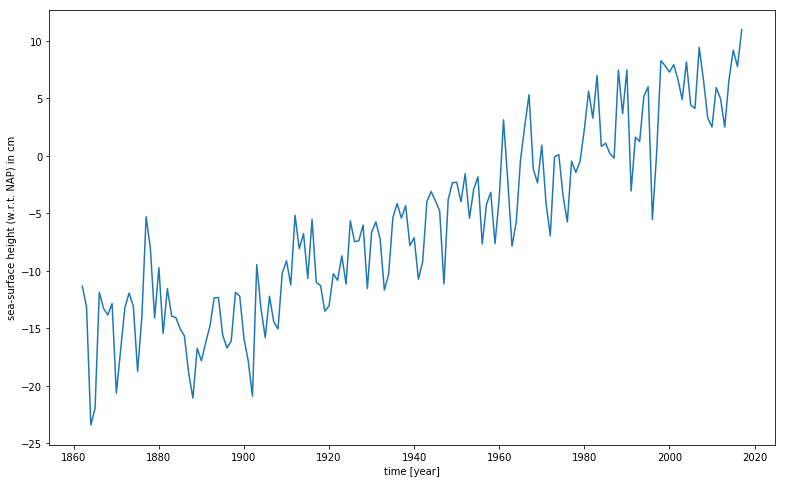

In [14]:
fig, ax = plt.subplots(figsize=(13, 8))
ax.plot(mean_df.index, mean_df['sea_level'])
ax.set_ylabel('sea-surface height (w.r.t. NAP) in cm')
ax.set_xlabel('time [year]');


In [15]:
mean_df.tail(n=15)

,sea_level
year,
2003,4.893056
2004,8.169444
2005,4.420833
2006,4.119444
2007,9.427778
2008,6.613889
2009,3.306944
2010,2.505556
2011,5.938889


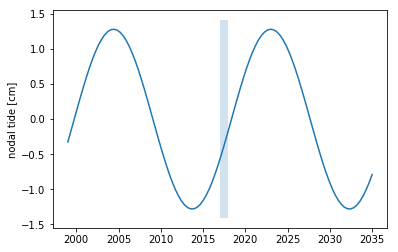

In [42]:
# check the current phase of nodal tide, u,v from sea-level monitor
tau = np.pi * 2
t = np.linspace(current_year - 18, current_year + 18, num=100)
nodal_tide = 7.5367*np.cos(tau*(t - 1970)/18.6) + -10.3536*np.sin(tau*(t - 1970)/18.6) 
plt.plot(t, nodal_tide/10);
plt.ylabel('nodal tide [cm]')
plt.fill_between([2017, 2018], *plt.ylim(), alpha=0.2)
amplitude = np.sqrt(7.5367**2 + (-10.3536)**2)
nodal_tide

In [45]:
2004.5 + 18.6

2023.1